<a href="https://colab.research.google.com/github/lym0405/simple_homepage/blob/main/%E1%84%8B%E1%85%A1%E1%86%AF%E1%84%80%E1%85%A9%E1%84%85%E1%85%B5%E1%84%83%E1%85%B3%E1%86%B7_%EA%B0%9C%EC%9D%B8%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터 로드 및 MA 진행

In [ ]:
pip install yfinance pandas matplotlib seaborn

In [ ]:
import os, json
from datetime import datetime
import numpy as nd
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# 한 셀에서 실행: yfinance에서 다운로드(신세계 + S&P500) -> 안전히 Adj Close 추출 -> CSV 저장
tickers_sinsegae = "004170.KS"
tickers_sp500 =  "^GSPC"
START = "2023-08-29"
END   = "2025-08-29"

df_sin = yf.download(tickers_sinsegae,
                     start = START,
                     end = END,
                     auto_adjust = True)

df_sp500 = yf.download(tickers_sp500,
                       start= START,
                       end=END,
                       auto_adjust=True)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
# Adjusted Close와 Volume만 추출해서 CSV로 저장
import os
import pandas as pd
os.makedirs('./data', exist_ok=True)

adj_sin = df_sin['Close'] if 'Close' in df_sin.columns else df_sin['Adj Close']
vol_sin = df_sin['Volume']
adj_sp = df_sp500['Close'] if 'Close' in df_sp500.columns else df_sp500['Adj Close']
vol_sp = df_sp500['Volume']

# Concatenate the series into a single DataFrame with appropriate column names
prices = pd.concat([adj_sin, adj_sp], axis=1)
prices.columns = ['SHINSEGAE', 'SP500']

volumes = pd.concat([vol_sin, vol_sp], axis=1)
volumes.columns = ['SHINSEGAE_Volume', 'SP500_Volume']

prices.to_csv('./data/prices_adj.csv', index=True)
volumes.to_csv('./data/volumes.csv', index=True)

print('Saved ./data/prices_adj.csv, ./data/volumes.csv')

Saved ./data/prices_adj.csv, ./data/volumes.csv


### 5, 20, 60일 이동평균(MA) 계산
앞서 저장한 가격 데이터(`prices_adj.csv`)를 불러와 각 주식의 5일, 20일, 60일 이동평균을 계산합니다.

In [ ]:
import pandas as pd
import os

DATA_DIR = './data'
adj_path = os.path.join(DATA_DIR, "prices_adj.csv")
sma_path = os.path.join(DATA_DIR, "prices_with_sma.csv")

# 1. Load data
try:
    # Load with Date as index and parse dates
    adj_df = pd.read_csv(adj_path, index_col=0, parse_dates=True)
except Exception as e:
    print(f"CSV 로드 실패: {e}. 메모리 데이터로 재시도.")
    # Fallback to in-memory `prices` DataFrame if it exists
    try:
        adj_df = prices.copy()
        adj_df.index = pd.to_datetime(adj_df.index)
    except NameError:
        raise RuntimeError("CSV 파일도 없고 'prices' 데이터프레임도 메모리에 없습니다. 이전 셀을 실행하세요.")

# Ensure all columns are numeric before calculating rolling mean
for col in adj_df.columns:
    adj_df[col] = pd.to_numeric(adj_df[col], errors='coerce')

# 2. Calculate Moving Averages
df_sma = adj_df.copy()
for col in adj_df.columns:
    # Check if the column is numeric before applying rolling mean
    if pd.api.types.is_numeric_dtype(df_sma[col]):
        for w in [5, 20, 60]:
            # Calculate rolling mean and assign directly
            df_sma[f"{col}_SMA_{w}"] = adj_df[col].rolling(window=w, min_periods=1).mean()
    else:
        print(f"Warning: Column '{col}' is not numeric and will be skipped for SMA calculation.")


# 3. Save to CSV
df_sma.to_csv(sma_path)
print(f"이동평균이 포함된 데이터를 '{sma_path}'에 저장했습니다.")

# 4. Display head
print("\n계산된 이동평균 (상위 5개 행):")
print(df_sma.head())

이동평균이 포함된 데이터를 './data/prices_with_sma.csv'에 저장했습니다.

계산된 이동평균 (상위 5개 행):
                SHINSEGAE        SP500  SHINSEGAE_SMA_5  SHINSEGAE_SMA_20  \
Date                                                                        
2023-08-29  192829.078125  4497.629883    192829.078125     192829.078125   
2023-08-30  191881.515625  4514.870117    192355.296875     192355.296875   
2023-08-31  192355.296875  4507.660156    192355.296875     192355.296875   
2023-09-01  193776.625000  4515.770020    192710.628906     192710.628906   
2023-09-04  197093.109375          NaN    193587.125000     193587.125000   

            SHINSEGAE_SMA_60  SP500_SMA_5  SP500_SMA_20  SP500_SMA_60  
Date                                                                   
2023-08-29     192829.078125  4497.629883   4497.629883   4497.629883  
2023-08-30     192355.296875  4506.250000   4506.250000   4506.250000  
2023-08-31     192355.296875  4506.720052   4506.720052   4506.720052  
2023-09-01     192710.6289

### 거래량 5, 20, 60일 이동평균(MA) 계산
`volumes.csv` 데이터를 사용하여 거래량에 대한 5일, 20일, 60일 이동평균을 계산합니다.

In [ ]:
import pandas as pd
import os

DATA_DIR = './data'
vol_path = os.path.join(DATA_DIR, "volumes.csv")
vol_sma_path = os.path.join(DATA_DIR, "volumes_with_sma.csv")

# 1. Load data
vol_df = pd.read_csv(vol_path, index_col=0, parse_dates=True)

# Ensure all columns are numeric before calculating rolling mean
for col in vol_df.columns:
    vol_df[col] = pd.to_numeric(vol_df[col], errors='coerce')

# 2. Calculate Moving Averages for Volume
df_vol_sma = vol_df.copy()
for col in vol_df.columns:
    # Check if the column is numeric before applying rolling mean
    if pd.api.types.is_numeric_dtype(df_vol_sma[col]):
        for w in [5, 20, 60]:
            # Calculate rolling mean for volume
            df_vol_sma[f"{col}_SMA_{w}"] = vol_df[col].rolling(window=w, min_periods=1).mean()
    else:
        print(f"Warning: Column '{col}' is not numeric and will be skipped for SMA calculation.")


# 3. Save to CSV
df_vol_sma.to_csv(vol_sma_path)
print(f"거래량 이동평균이 포함된 데이터를 '{vol_sma_path}'에 저장했습니다.")

# 4. Display head
print("\n계산된 거래량 이동평균 (상위 5개 행):")
print(df_vol_sma.head())

거래량 이동평균이 포함된 데이터를 './data/volumes_with_sma.csv'에 저장했습니다.

계산된 거래량 이동평균 (상위 5개 행):
            SHINSEGAE_Volume  SP500_Volume  SHINSEGAE_Volume_SMA_5  \
Date                                                                 
2023-08-29           47277.0  3.354820e+09            47277.000000   
2023-08-30           64772.0  3.064110e+09            56024.500000   
2023-08-31           51437.0  3.946360e+09            54495.333333   
2023-09-01           66107.0  3.246260e+09            57398.250000   
2023-09-04           65770.0           NaN            59072.600000   

            SHINSEGAE_Volume_SMA_20  SHINSEGAE_Volume_SMA_60  \
Date                                                           
2023-08-29             47277.000000             47277.000000   
2023-08-30             56024.500000             56024.500000   
2023-08-31             54495.333333             54495.333333   
2023-09-01             57398.250000             57398.250000   
2023-09-04             59072.600000       

# MA plot
Visualize the 5, 20, and 60-day moving averages for both price and volume of Shinsegae and S&P 500. Create separate plots for each moving average period and a combined plot showing all moving averages for both price and volume.

## 신세계 가격 이동평균 시각화 (개별)

### Subtask:
신세계의 가격 이동평균(5일, 20일, 60일)을 각각 별도의 그래프로 시각화하고 원본 가격 데이터를 기준선으로 추가합니다.

**Reasoning**:
Plot the 5-day moving average and the original price data for Shinsegae from the `df_sma` DataFrame.

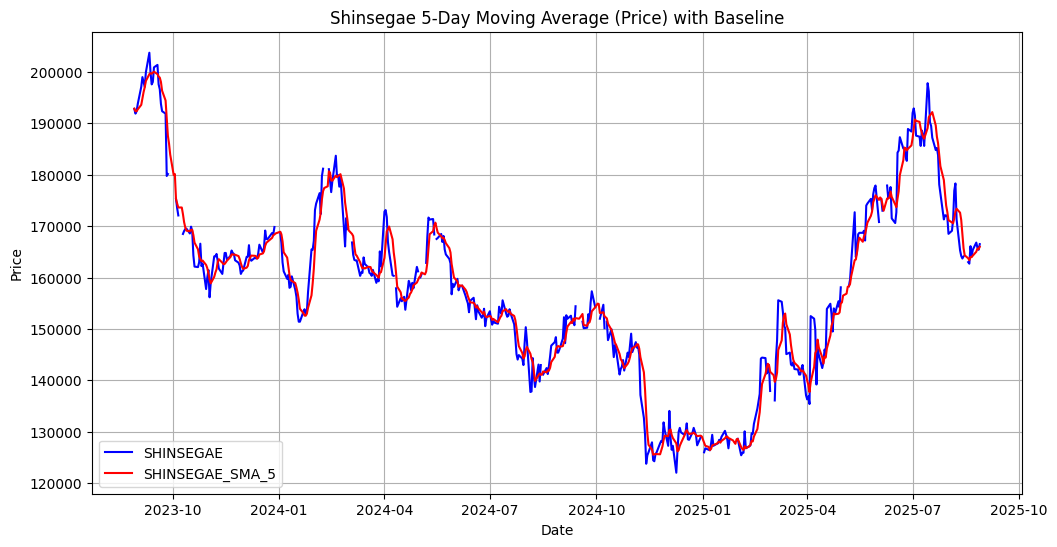

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SHINSEGAE'], label='SHINSEGAE', color='blue')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_5'], label='SHINSEGAE_SMA_5', color='red')
plt.title('Shinsegae 5-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Plot the 20-day moving average and the original price data for Shinsegae from the `df_sma` DataFrame.

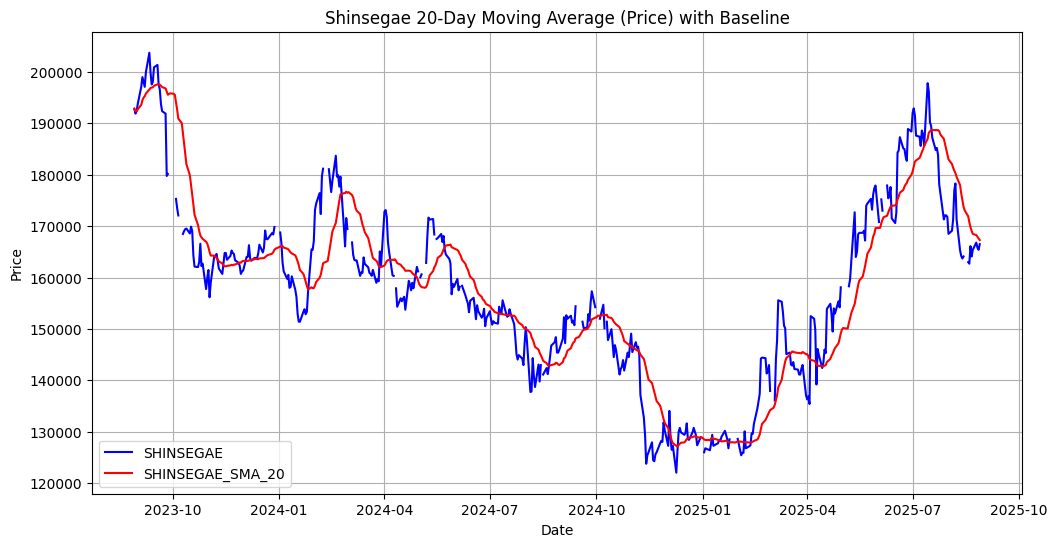

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SHINSEGAE'], label='SHINSEGAE', color='blue')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_20'], label='SHINSEGAE_SMA_20', color='red')
plt.title('Shinsegae 20-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Plot the 60-day moving average and the original price data for Shinsegae from the `df_sma` DataFrame.

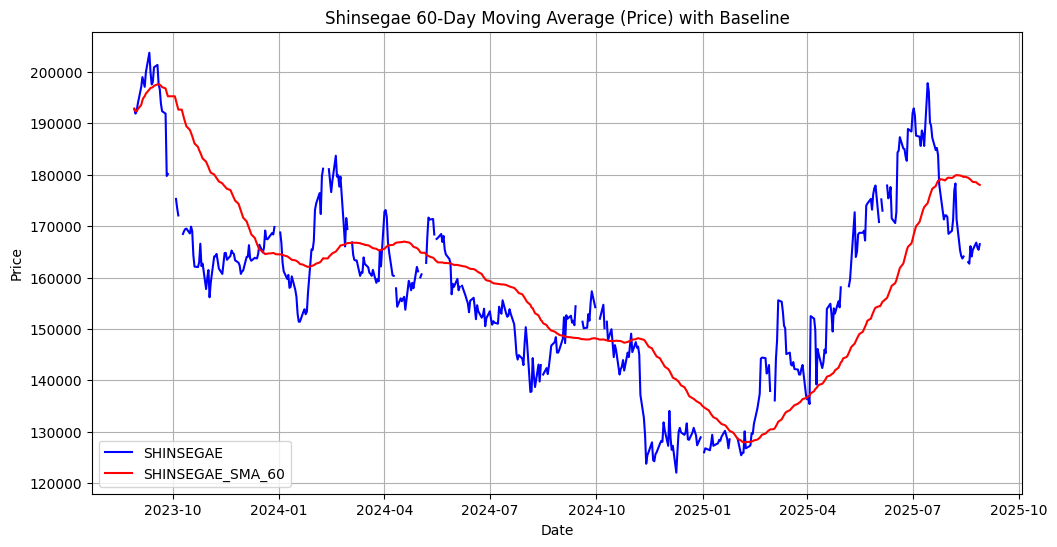

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SHINSEGAE'], label='SHINSEGAE', color='blue')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_60'], label='SHINSEGAE_SMA_60', color='red')
plt.title('Shinsegae 60-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## S&P 500 가격 이동평균 시각화 (개별)

### Subtask:
S&P 500의 가격 이동평균(5일, 20일, 60일)을 각각 별도의 그래프로 시각화하고 원본 가격 데이터를 기준선으로 추가합니다.

**Reasoning**:
Plot the 5-day moving average and the original price data for S&P 500 from the `df_sma` DataFrame.

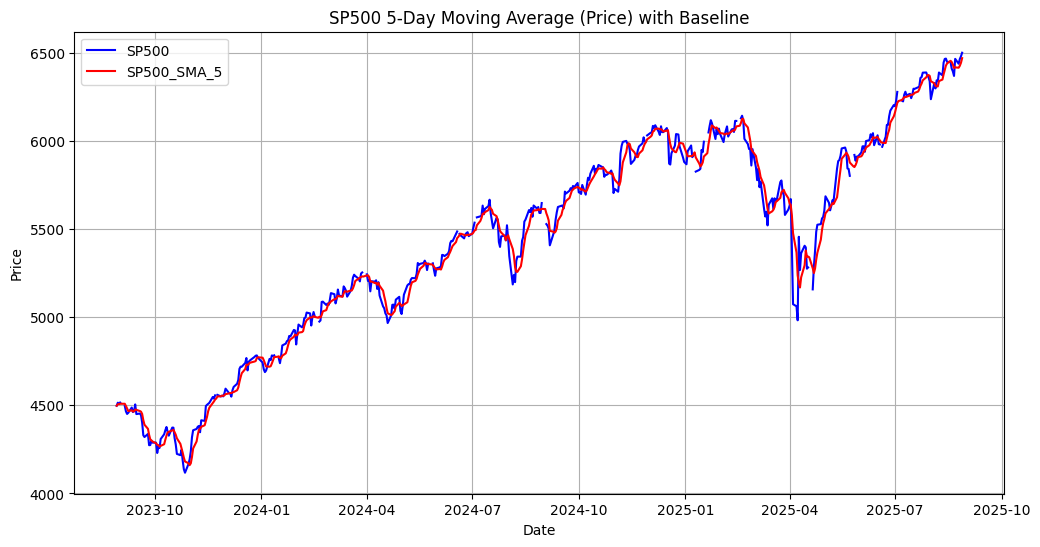

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SP500'], label='SP500', color='blue')
plt.plot(df_sma.index, df_sma['SP500_SMA_5'], label='SP500_SMA_5', color='red')
plt.title('SP500 5-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Plot the 20-day moving average and the original price data for S&P 500 from the `df_sma` DataFrame.

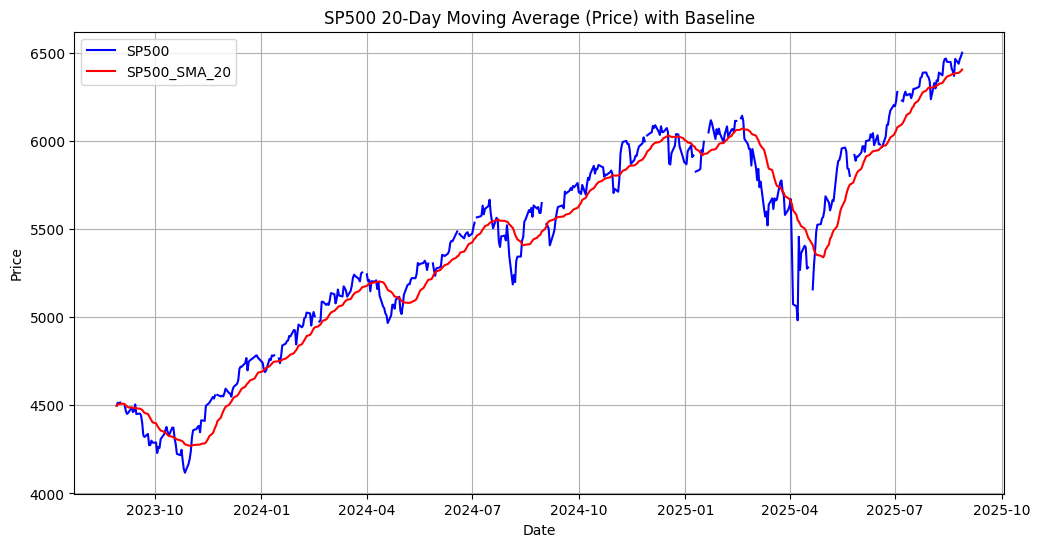

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SP500'], label='SP500', color='blue')
plt.plot(df_sma.index, df_sma['SP500_SMA_20'], label='SP500_SMA_20', color='red')
plt.title('SP500 20-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

**Reasoning**:
Plot the 60-day moving average and the original price data for S&P 500 from the `df_sma` DataFrame.

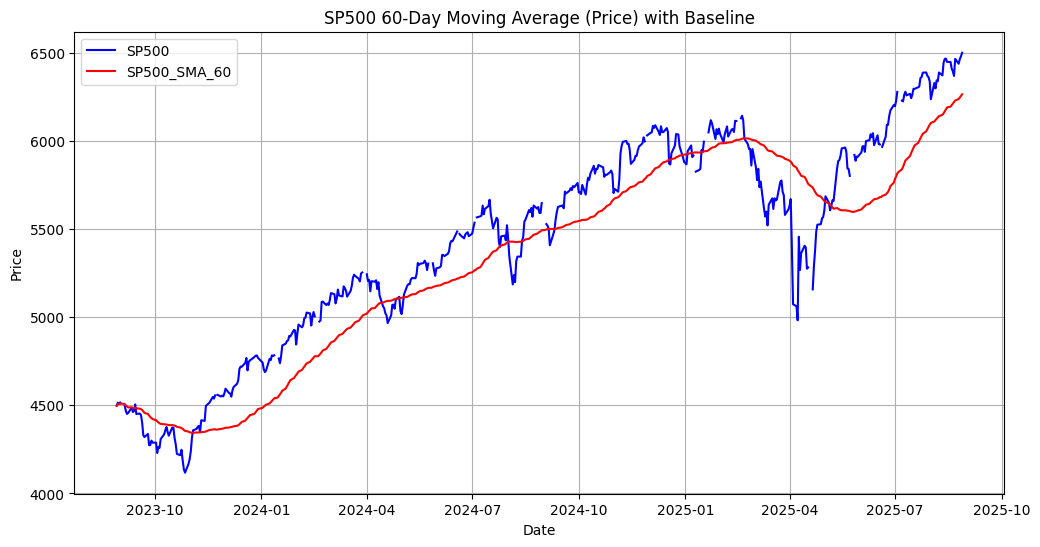

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SP500'], label='SP500', color='blue')
plt.plot(df_sma.index, df_sma['SP500_SMA_60'], label='SP500_SMA_60', color='red')
plt.title('SP500 60-Day Moving Average (Price) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 신세계 가격 이동평균 시각화 (통합)

### Subtask:
신세계의 모든 가격 이동평균(5일, 20일, 60일)을 하나의 그래프에 통합하여 시각화합니다.

**Reasoning**:
Plot the original price data and the 5, 20, and 60-day moving averages for Shinsegae on a single graph using the `df_sma` DataFrame.

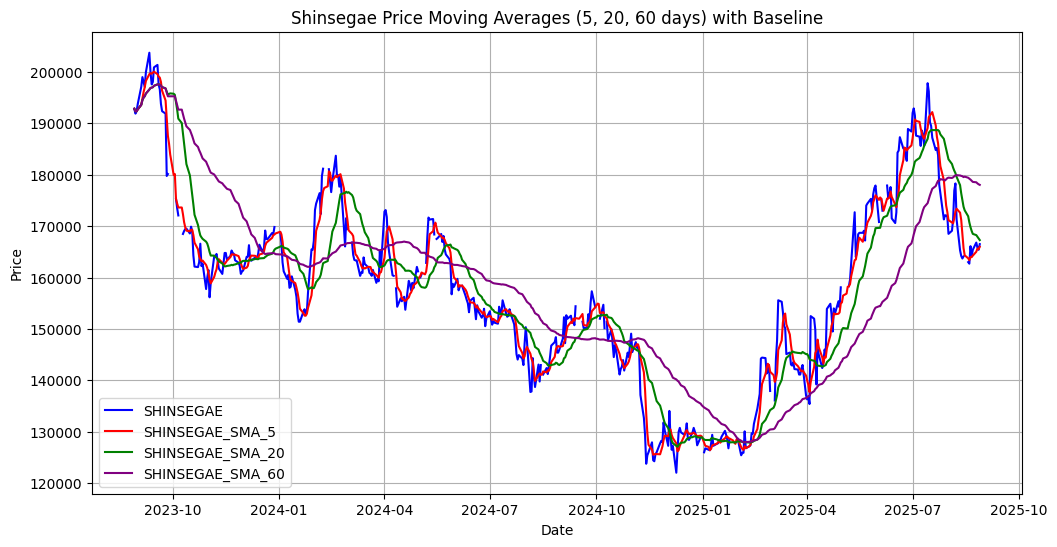

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SHINSEGAE'], label='SHINSEGAE', color='blue')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_5'], label='SHINSEGAE_SMA_5', color='red')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_20'], label='SHINSEGAE_SMA_20', color='green')
plt.plot(df_sma.index, df_sma['SHINSEGAE_SMA_60'], label='SHINSEGAE_SMA_60', color='purple')
plt.title('Shinsegae Price Moving Averages (5, 20, 60 days) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## S&P 500 가격 이동평균 시각화 (통합)

### Subtask:
S&P 500의 모든 가격 이동평균(5일, 20일, 60일)을 하나의 그래프에 통합하여 시각화합니다.

**Reasoning**:
Plot the original price data and the 5, 20, and 60-day moving averages for S&P 500 on a single graph using the `df_sma` DataFrame.

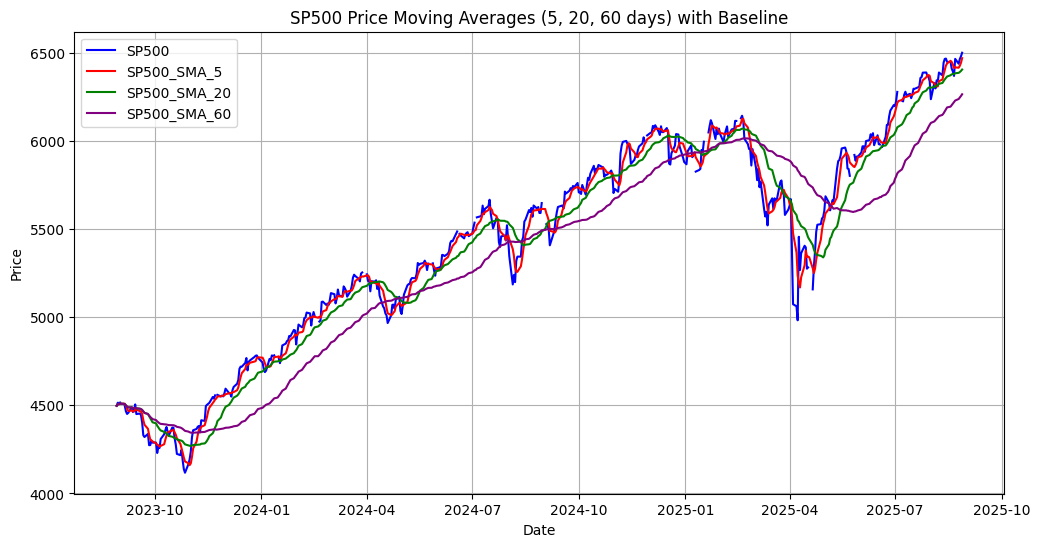

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df_sma.index, df_sma['SP500'], label='SP500', color='blue')
plt.plot(df_sma.index, df_sma['SP500_SMA_5'], label='SP500_SMA_5', color='red')
plt.plot(df_sma.index, df_sma['SP500_SMA_20'], label='SP500_SMA_20', color='green')
plt.plot(df_sma.index, df_sma['SP500_SMA_60'], label='SP500_SMA_60', color='purple')
plt.title('SP500 Price Moving Averages (5, 20, 60 days) with Baseline')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## 주가 이동평균 계산 및 시각화 (주가 및 거래량 차트 함께 표시)

### Subtask:
주가 데이터에 대한 이동평균을 계산하고, 계산된 이동평균을 주가 차트에 표시한 후, 그 아래에 해당 기간의 거래량 차트를 함께 표시합니다.

**Reasoning**:
Ensure SMA for price is calculated (using the existing `df_sma` if available), and then create a figure with two subplots: the top one showing the price with 5, 20, and 60-day SMAs, and the bottom one showing the volume.

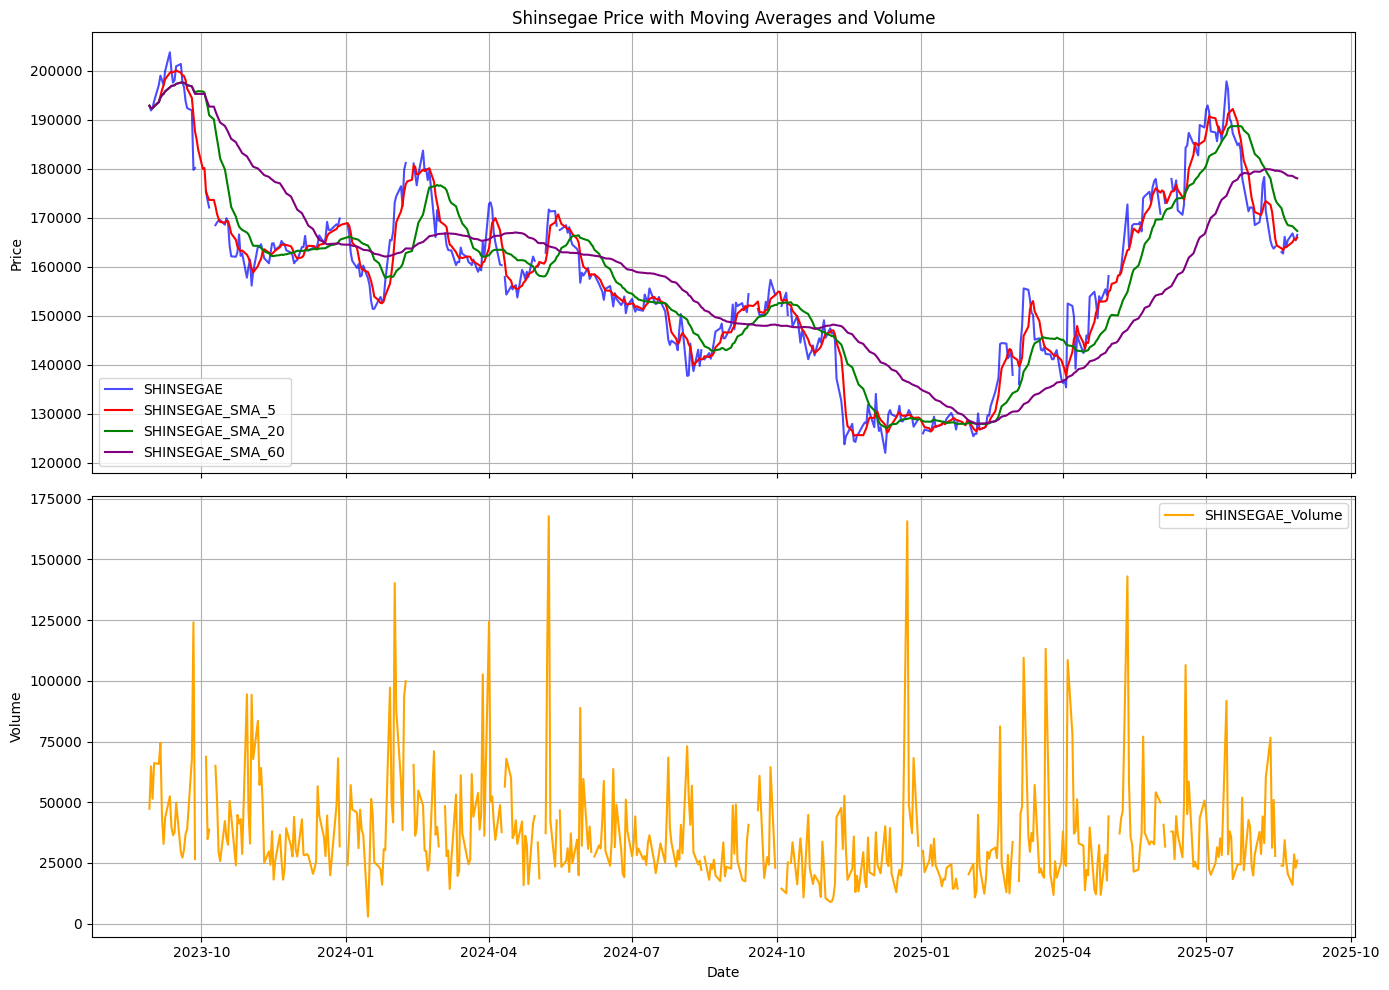

In [ ]:
# Ensure df_sma is available and contains SMA columns
# Assuming df_sma is already calculated from previous steps and contains 'SHINSEGAE', 'SP500', and their SMA columns

# Create a figure with two subplots (one for price, one for volume)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Price and SMAs on the top subplot
axes[0].plot(df_sma.index, df_sma['SHINSEGAE'], label='SHINSEGAE', color='blue', alpha=0.7)
axes[0].plot(df_sma.index, df_sma['SHINSEGAE_SMA_5'], label='SHINSEGAE_SMA_5', color='red')
axes[0].plot(df_sma.index, df_sma['SHINSEGAE_SMA_20'], label='SHINSEGAE_SMA_20', color='green')
axes[0].plot(df_sma.index, df_sma['SHINSEGAE_SMA_60'], label='SHINSEGAE_SMA_60', color='purple')
axes[0].set_ylabel('Price')
axes[0].set_title('Shinsegae Price with Moving Averages and Volume')
axes[0].legend()
axes[0].grid(True)

# Plot Volume on the bottom subplot
# Assuming df_vol_sma is available and contains 'SHINSEGAE_Volume'
axes[1].plot(df_vol_sma.index, df_vol_sma['SHINSEGAE_Volume'], label='SHINSEGAE_Volume', color='orange')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

## S&P 500 주가 이동평균 계산 및 시각화 (주가 및 거래량 차트 함께 표시)

### Subtask:
S&P 500 주가 데이터에 대한 이동평균을 계산하고, 계산된 이동평균을 주가 차트에 표시한 후, 그 아래에 해당 기간의 거래량 차트를 함께 표시합니다.

**Reasoning**:
Create a figure with two subplots for S&P 500: the top one showing the price with 5, 20, and 60-day SMAs, and the bottom one showing the volume.

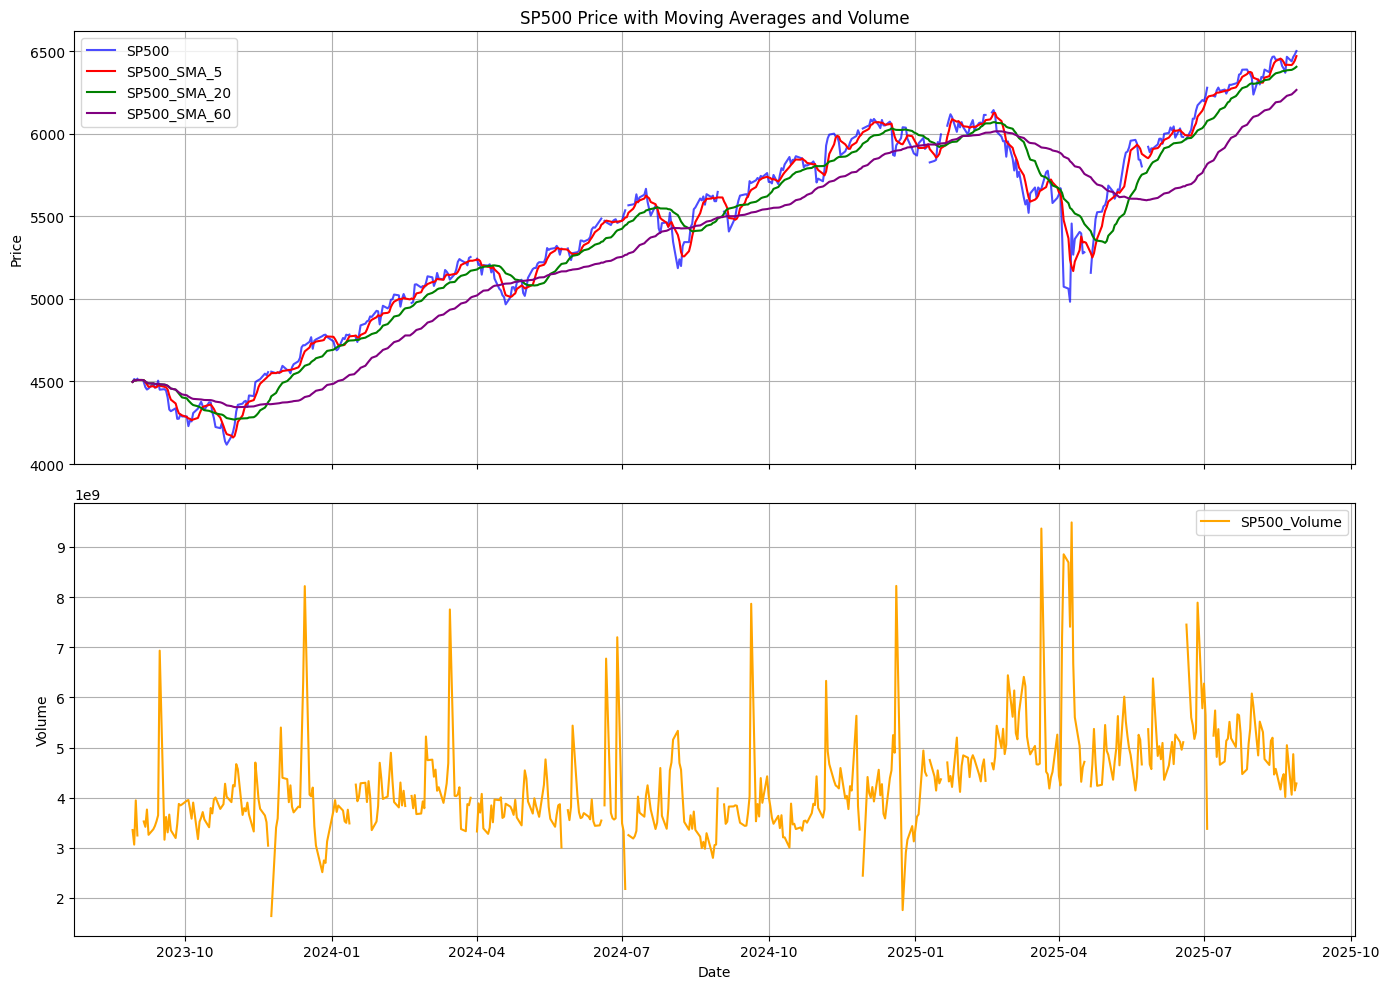

In [ ]:
# Assuming df_sma and df_vol_sma are available and contain the necessary S&P 500 data

# Create a figure with two subplots (one for price, one for volume)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot Price and SMAs on the top subplot
axes[0].plot(df_sma.index, df_sma['SP500'], label='SP500', color='blue', alpha=0.7)
axes[0].plot(df_sma.index, df_sma['SP500_SMA_5'], label='SP500_SMA_5', color='red')
axes[0].plot(df_sma.index, df_sma['SP500_SMA_20'], label='SP500_SMA_20', color='green')
axes[0].plot(df_sma.index, df_sma['SP500_SMA_60'], label='SP500_SMA_60', color='purple')
axes[0].set_ylabel('Price')
axes[0].set_title('SP500 Price with Moving Averages and Volume')
axes[0].legend()
axes[0].grid(True)

# Plot Volume on the bottom subplot
axes[1].plot(df_vol_sma.index, df_vol_sma['SP500_Volume'], label='SP500_Volume', color='orange')
axes[1].set_ylabel('Volume')
axes[1].set_xlabel('Date')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Tuning & 성능 시스템
Calculate and visualize various types of moving averages (WMA, Smoothing MA, EMA) for both price and volume data of Shinsegae and S&P, using different window/span and decay/smoothing parameters. Define and calculate evaluation metrics (Bias, Variance, Trend Strength) for each moving average combination. Implement a scoring system based on these metrics to find the optimal moving average combination. Select the optimal combination based on the scores and visualize its results alongside the original data. Finally, provide an explanation of the optimal combination selection process and the results.

## 다양한 이동평균 계산

### Subtask:
가격 및 거래량 데이터에 대해 WMA, 스무딩 이동평균, EMA를 다양한 윈도우/스팬 및 Decay/Smoothing 파라미터로 계산합니다.


**Reasoning**:
Calculate WMA, Smoothing MA, and EMA for both price and volume data with specified parameters as requested by the instructions.



In [ ]:
# 1. Calculate WMA for Price
df_wma = adj_df.copy()
for col in ['SHINSEGAE', 'SP500']:
    for w in [5, 20, 60]:
        weights = nd.arange(1, w + 1)
        df_wma[f"{col}_WMA_{w}"] = adj_df[col].rolling(window=w).apply(lambda x: nd.dot(x, weights) / weights.sum(), raw=True)

# 2. Calculate Smoothing MA for Price
df_smoothing = adj_df.copy()
for col in ['SHINSEGAE', 'SP500']:
    for w in [5, 20, 60]:
        df_smoothing[f"{col}_Smoothing_{w}"] = adj_df[col].rolling(window=w).mean().ewm(span=w, adjust=False).mean()

# 3. Calculate EMA for Price
df_ema = adj_df.copy()
for col in ['SHINSEGAE', 'SP500']:
    for span in [5, 20, 60]:
        df_ema[f"{col}_EMA_{span}"] = adj_df[col].ewm(span=span, adjust=False).mean()

# 4. Calculate WMA for Volume
df_vol_wma = vol_df.copy()
for col in ['SHINSEGAE_Volume', 'SP500_Volume']:
    for w in [5, 20, 60]:
        weights = nd.arange(1, w + 1)
        df_vol_wma[f"{col}_WMA_{w}"] = vol_df[col].rolling(window=w).apply(lambda x: nd.dot(x, weights) / weights.sum(), raw=True)

# 5. Calculate Smoothing MA for Volume
df_vol_smoothing = vol_df.copy()
for col in ['SHINSEGAE_Volume', 'SP500_Volume']:
    for w in [5, 20, 60]:
        df_vol_smoothing[f"{col}_Smoothing_{w}"] = vol_df[col].rolling(window=w).mean().ewm(span=w, adjust=False).mean()


# 6. Calculate EMA for Volume
df_vol_ema = vol_df.copy()
for col in ['SHINSEGAE_Volume', 'SP500_Volume']:
    for span in [5, 20, 60]:
        df_vol_ema[f"{col}_EMA_{span}"] = vol_df[col].ewm(span=span, adjust=False).mean()

# 7. Display head of each calculated DataFrame
print("df_wma head:")
display(df_wma.head())

print("\ndf_smoothing head:")
display(df_smoothing.head())

print("\ndf_ema head:")
display(df_ema.head())

print("\ndf_vol_wma head:")
display(df_vol_wma.head())

print("\ndf_vol_smoothing head:")
display(df_vol_smoothing.head())

print("\ndf_vol_ema head:")
display(df_vol_ema.head())

df_wma head:


,SHINSEGAE,SP500,SHINSEGAE_WMA_5,SHINSEGAE_WMA_20,SHINSEGAE_WMA_60,SP500_WMA_5,SP500_WMA_20,SP500_WMA_60
Date,,,,,,,,
2023-08-29,192829.078125,4497.629883,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-30,191881.515625,4514.870117,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,192355.296875,4507.660156,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01,193776.625000,4515.770020,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-04,197093.109375,NaN,194282.003125,NaN,NaN,NaN,NaN,NaN



df_smoothing head:


,SHINSEGAE,SP500,SHINSEGAE_Smoothing_5,SHINSEGAE_Smoothing_20,SHINSEGAE_Smoothing_60,SP500_Smoothing_5,SP500_Smoothing_20,SP500_Smoothing_60
Date,,,,,,,,
2023-08-29,192829.078125,4497.629883,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-30,191881.515625,4514.870117,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,192355.296875,4507.660156,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01,193776.625000,4515.770020,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-04,197093.109375,NaN,193587.125,NaN,NaN,NaN,NaN,NaN



df_ema head:


,SHINSEGAE,SP500,SHINSEGAE_EMA_5,SHINSEGAE_EMA_20,SHINSEGAE_EMA_60,SP500_EMA_5,SP500_EMA_20,SP500_EMA_60
Date,,,,,,,,
2023-08-29,192829.078125,4497.629883,192829.078125,192829.078125,192829.078125,4497.629883,4497.629883,4497.629883
2023-08-30,191881.515625,4514.870117,192513.223958,192738.834077,192798.010502,4503.376628,4499.271810,4498.195136
2023-08-31,192355.296875,4507.660156,192460.581597,192702.306725,192783.495301,4504.804470,4500.070700,4498.505465
2023-09-01,193776.625000,4515.770020,192899.262731,192804.622751,192816.056931,4508.459654,4501.565873,4499.071516
2023-09-04,197093.109375,NaN,194297.211613,193213.050049,192956.288158,4508.459654,4501.565873,4499.071516



df_vol_wma head:


,SHINSEGAE_Volume,SP500_Volume,SHINSEGAE_Volume_WMA_5,SHINSEGAE_Volume_WMA_20,SHINSEGAE_Volume_WMA_60,SP500_Volume_WMA_5,SP500_Volume_WMA_20,SP500_Volume_WMA_60
Date,,,,,,,,
2023-08-29,47277.0,3.354820e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-30,64772.0,3.064110e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,51437.0,3.946360e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01,66107.0,3.246260e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-04,65770.0,NaN,61627.333333,NaN,NaN,NaN,NaN,NaN



df_vol_smoothing head:


,SHINSEGAE_Volume,SP500_Volume,SHINSEGAE_Volume_Smoothing_5,SHINSEGAE_Volume_Smoothing_20,SHINSEGAE_Volume_Smoothing_60,SP500_Volume_Smoothing_5,SP500_Volume_Smoothing_20,SP500_Volume_Smoothing_60
Date,,,,,,,,
2023-08-29,47277.0,3.354820e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-30,64772.0,3.064110e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-08-31,51437.0,3.946360e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-01,66107.0,3.246260e+09,NaN,NaN,NaN,NaN,NaN,NaN
2023-09-04,65770.0,NaN,59072.6,NaN,NaN,NaN,NaN,NaN



df_vol_ema head:


,SHINSEGAE_Volume,SP500_Volume,SHINSEGAE_Volume_EMA_5,SHINSEGAE_Volume_EMA_20,SHINSEGAE_Volume_EMA_60,SP500_Volume_EMA_5,SP500_Volume_EMA_20,SP500_Volume_EMA_60
Date,,,,,,,,
2023-08-29,47277.0,3.354820e+09,47277.000000,47277.000000,47277.000000,3.354820e+09,3.354820e+09,3.354820e+09
2023-08-30,64772.0,3.064110e+09,53108.666667,48943.190476,47850.606557,3.257917e+09,3.327133e+09,3.345289e+09
2023-08-31,51437.0,3.946360e+09,52551.444444,49180.696145,47968.193228,3.487398e+09,3.386107e+09,3.364996e+09
2023-09-01,66107.0,3.246260e+09,57069.962963,50792.725084,48562.908204,3.407019e+09,3.372789e+09,3.361103e+09
2023-09-04,65770.0,NaN,59969.975309,52219.132219,49127.075148,3.407019e+09,3.372789e+09,3.361103e+09


## 평가 지표 정의 및 계산

### Subtask:
Bias, Variance, 추세 강도 등 이동평균의 성능을 평가할 수 있는 지표를 정의하고 각 이동평균 조합에 대해 계산합니다.


**Reasoning**:
Calculate Bias, Variance, and Trend Strength for each moving average and store them in a DataFrame.



In [ ]:
# Helper function to calculate trend strength using linear regression slope
from scipy.stats import linregress

def calculate_trend_strength(series):
    # Drop NaN values to fit linear regression
    series_clean = series.dropna()
    if len(series_clean) < 2:
        return nd.nan
    # Use index as x-values (time proxy)
    x = nd.arange(len(series_clean))
    slope, _, _, _, _ = linregress(x, series_clean.values)
    return abs(slope)

# Initialize a list to store metrics
metrics_list = []

# Process Price Moving Averages
price_dfs = {'WMA': df_wma, 'Smoothing': df_smoothing, 'EMA': df_ema}
price_cols = ['SHINSEGAE', 'SP500']

for ma_type, ma_df in price_dfs.items():
    for original_col in price_cols:
        original_data = adj_df[original_col]
        for ma_col in ma_df.columns:
            if ma_col.startswith(original_col) and f'_{ma_type}_' in ma_col:
                ma_data = ma_df[ma_col]

                # Calculate Bias
                bias = (original_data - ma_data).mean()

                # Calculate Variance
                variance = (original_data - ma_data).var()

                # Calculate Trend Strength of Original and MA
                original_trend_strength = calculate_trend_strength(original_data)
                ma_trend_strength = calculate_trend_strength(ma_data)

                # Store metrics
                metrics_list.append({
                    'Asset': original_col,
                    'Type': 'Price',
                    'MA_Type': ma_type,
                    'MA_Column': ma_col,
                    'Bias': bias,
                    'Variance': variance,
                    'Original_Trend_Strength': original_trend_strength,
                    'MA_Trend_Strength': ma_trend_strength
                })

# Process Volume Moving Averages
volume_dfs = {'WMA': df_vol_wma, 'Smoothing': df_vol_smoothing, 'EMA': df_vol_ema}
volume_cols = ['SHINSEGAE_Volume', 'SP500_Volume']

for ma_type, ma_df in volume_dfs.items():
    for original_col in volume_cols:
        original_data = vol_df[original_col]
        for ma_col in ma_df.columns:
            if ma_col.startswith(original_col) and f'_{ma_type}_' in ma_col:
                 ma_data = ma_df[ma_col]

                 # Calculate Bias
                 bias = (original_data - ma_data).mean()

                 # Calculate Variance
                 variance = (original_data - ma_data).var()

                 # Calculate Trend Strength of Original and MA
                 original_trend_strength = calculate_trend_strength(original_data)
                 ma_trend_strength = calculate_trend_strength(ma_data)

                 # Store metrics
                 metrics_list.append({
                     'Asset': original_col,
                     'Type': 'Volume',
                     'MA_Type': ma_type,
                     'MA_Column': ma_col,
                     'Bias': bias,
                     'Variance': variance,
                     'Original_Trend_Strength': original_trend_strength,
                     'MA_Trend_Strength': ma_trend_strength
                 })


# Convert metrics list to DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the metrics DataFrame
display(metrics_df)

,Asset,Type,MA_Type,MA_Column,Bias,Variance,Original_Trend_Strength,MA_Trend_Strength
0,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_5,-4.025048e+01,5.598244e+06,3.075366e+01,3.212984e+01
1,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_20,-4.666898e+02,3.337075e+07,3.075366e+01,4.842892e+00
2,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_60,NaN,NaN,3.075366e+01,NaN
3,SP500,Price,WMA,SP500_WMA_5,5.257359e+00,1.906142e+03,3.784446e+00,4.463237e+00
4,SP500,Price,WMA,SP500_WMA_20,2.097397e+01,1.025326e+04,3.784446e+00,9.733602e+00
5,SP500,Price,WMA,SP500_WMA_60,1.523092e+02,2.667825e+02,3.784446e+00,7.743511e+00
6,SHINSEGAE,Price,Smoothing,SHINSEGAE_Smoothing_5,-4.207132e+02,2.832329e+07,3.075366e+01,3.493917e+01
7,SHINSEGAE,Price,Smoothing,SHINSEGAE_Smoothing_20,3.719872e+02,2.023008e+08,3.075366e+01,5.585732e+01
8,SHINSEGAE,Price,Smoothing,SHINSEGAE_Smoothing_60,NaN,NaN,3.075366e+01,NaN
9,SP500,Price,Smoothing,SP500_Smoothing_5,1.753352e+01,6.798730e+03,3.784446e+00,3.639232e+00


## 점수 시스템 구현

### Subtask:
계산된 평가 지표를 바탕으로 각 이동평균 조합의 '점수'를 계산하는 로직을 구현합니다.


**Reasoning**:
Implement a scoring system based on the calculated metrics and add the scores to the metrics_df DataFrame.



In [ ]:
# Normalize metrics for scoring (lower is better for Bias and Variance, closer to 1 is better for Trend Strength Ratio)
# Normalize within each asset type for better comparison within asset
metrics_df['Bias_Normalized'] = metrics_df.groupby('Asset')['Bias'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))
metrics_df['Variance_Normalized'] = metrics_df.groupby('Asset')['Variance'].transform(lambda x: (x - x.min()) / (x.max() - x.min()))


# Calculate Trend Strength Similarity (closer to 1 is better)
metrics_df['Trend_Similarity'] = 1 / (1 + abs(metrics_df['Original_Trend_Strength'] - metrics_df['MA_Trend_Strength']))

# Combine normalized metrics into a single score (lower is better for Bias and Variance, higher for Trend Similarity)
# A simple scoring approach: Score = (1 - Bias_Normalized) + (1 - Variance_Normalized) + Trend_Similarity
# We can adjust weights if needed, but for now, equal weighting.
metrics_df['Score'] = (1 - metrics_df['Bias_Normalized']) + (1 - metrics_df['Variance_Normalized']) + metrics_df['Trend_Similarity']

# Display the metrics DataFrame with the new 'Score' column
print("Metrics with calculated scores:")
display(metrics_df.head())

Metrics with calculated scores:


,Asset,Type,MA_Type,MA_Column,Bias,Variance,Original_Trend_Strength,MA_Trend_Strength,Bias_Normalized,Variance_Normalized,Trend_Similarity,Score
0,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_5,-40.250478,5.598244e+06,30.753657,32.129844,0.749318,0.000000,0.420842,1.671524
1,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_20,-466.689766,3.337075e+07,30.753657,4.842892,0.490000,0.141190,0.037160,1.405969
2,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_60,NaN,NaN,30.753657,NaN,NaN,NaN,NaN,NaN
3,SP500,Price,WMA,SP500_WMA_5,5.257359,1.906142e+03,3.784446,4.463237,0.000000,0.017159,0.595667,2.578508
4,SP500,Price,WMA,SP500_WMA_20,20.973971,1.025326e+04,3.784446,9.733602,0.086493,0.104527,0.143902,1.952883


## 최적 조합 선정

### Subtask:
계산된 점수를 비교하여 가장 높은 점수를 얻은 이동평균 조합을 선정합니다.


**Reasoning**:
Sort the metrics_df by the 'Score' column in descending order to find the best performing moving average combination and then display the top row which represents the optimal combination.



In [ ]:
# Sort the DataFrame by 'Score' in descending order within each Asset group
optimal_combinations = metrics_df.loc[metrics_df.groupby('Asset')['Score'].idxmax()]

# Print the optimal combinations for each asset
print("Optimal Moving Average Combination for Each Asset:")
display(optimal_combinations)

Optimal Moving Average Combination for Each Asset:


,Asset,Type,MA_Type,MA_Column,Bias,Variance,Original_Trend_Strength,MA_Trend_Strength,Bias_Normalized,Variance_Normalized,Trend_Similarity,Score
0,SHINSEGAE,Price,WMA,SHINSEGAE_WMA_5,-4.025048e+01,5.598244e+06,3.075366e+01,3.212984e+01,0.749318,0.000000,0.420842,1.671524
18,SHINSEGAE_Volume,Volume,WMA,SHINSEGAE_Volume_WMA_5,-1.958423e+02,2.015432e+08,2.747801e+01,2.799166e+01,0.184385,0.002698,0.660653,2.473571
15,SP500,Price,EMA,SP500_EMA_5,7.852752e+00,2.130412e+03,3.784446e+00,3.637681e+00,0.014283,0.019506,0.872018,2.838229
33,SP500_Volume,Volume,EMA,SP500_Volume_EMA_5,3.657400e+06,2.846214e+17,3.213751e+06,3.176743e+06,0.097179,0.000000,0.000027,1.902848


## 최적 조합 결과 시각화

### Subtask:
선정된 최적 이동평균 조합의 결과를 원본 데이터와 함께 시각화합니다.


**Reasoning**:
Extract the necessary information from the optimal combination and plot the original data and the optimal moving average on a single graph.



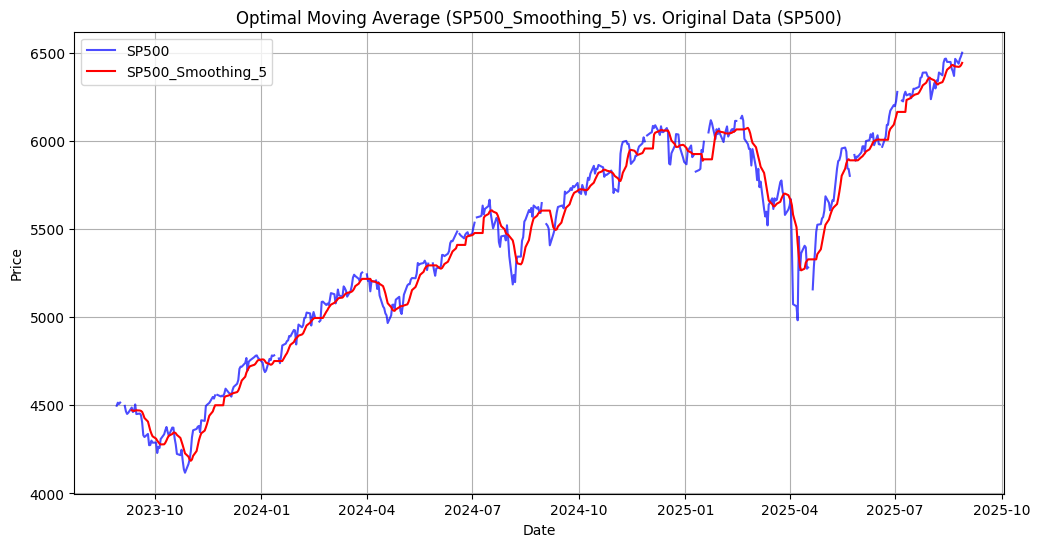

In [ ]:
# 1. Extract information from the optimal combination
asset = optimal_combination['Asset']
data_type = optimal_combination['Type']
ma_type = optimal_combination['MA_Type'] # Extract MA Type as well
ma_column = optimal_combination['MA_Column']

# 2. Get the original and MA data based on data type and MA type
if data_type == 'Price':
    original_data = adj_df[asset] # Use adj_df for original price data
    if ma_type == 'SMA': # Although SMA is not in optimal_combination, keep for completeness
         ma_data = df_sma[ma_column]
    elif ma_type == 'WMA':
         ma_data = df_wma[ma_column]
    elif ma_type == 'Smoothing':
         ma_data = df_smoothing[ma_column] # Use df_smoothing for Smoothing MA
    elif ma_type == 'EMA':
         ma_data = df_ema[ma_column]
    else:
        raise ValueError(f"Unknown MA Type: {ma_type}")
    y_label = 'Price'
elif data_type == 'Volume':
    original_data = vol_df[asset] # Use vol_df for original volume data
    if ma_type == 'SMA': # Although SMA is not in optimal_combination, keep for completeness
         ma_data = df_vol_sma[ma_column]
    elif ma_type == 'WMA':
         ma_data = df_vol_wma[ma_column]
    elif ma_type == 'Smoothing':
         ma_data = df_vol_smoothing[ma_column] # Use df_vol_smoothing for Smoothing MA
    elif ma_type == 'EMA':
         ma_data = df_vol_ema[ma_column]
    else:
        raise ValueError(f"Unknown MA Type: {ma_type}")
    y_label = 'Volume'
else:
    raise ValueError(f"Unknown data type in optimal_combination: {data_type}")


# 3. Create a new figure
plt.figure(figsize=(12, 6))

# 4. Plot original data and optimal MA
plt.plot(original_data.index, original_data, label=asset, color='blue', alpha=0.7)
plt.plot(ma_data.index, ma_data, label=ma_column, color='red')

# 5. Add title and labels
plt.title(f'Optimal Moving Average ({ma_column}) vs. Original Data ({asset})')
plt.xlabel('Date')
plt.ylabel(y_label)

# 6. Add legend
plt.legend()

# 7. Display grid
plt.grid(True)

# 8. Show plot
plt.show()

**Reasoning**:
The optimal combination's MA column 'SP500_Smoothing_5' was not found in `df_sma`. The previous step calculated smoothing MAs and stored them in `df_smoothing`. The code needs to use the correct DataFrame based on the MA Type.



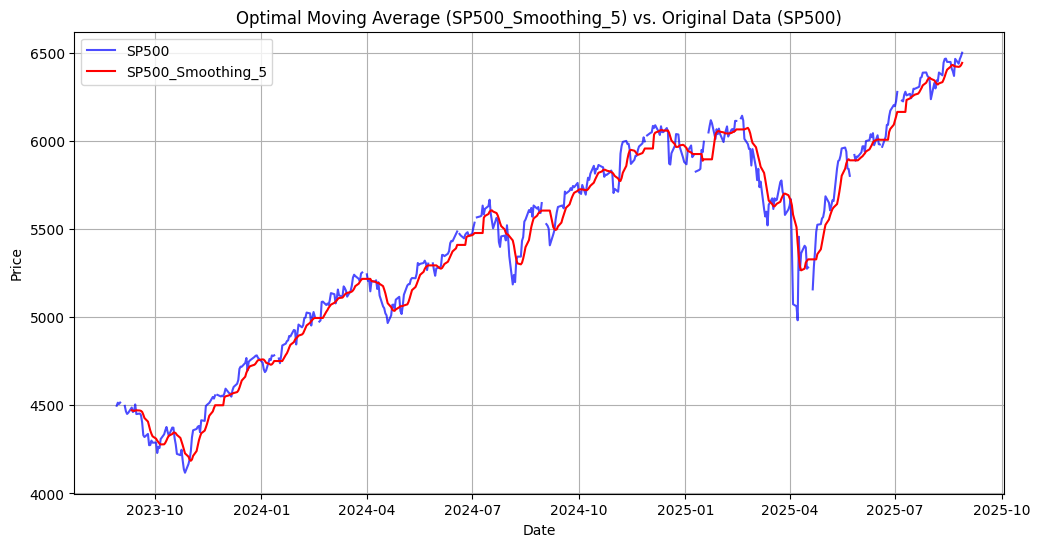

In [ ]:
# 1. Extract information from the optimal combination
asset = optimal_combination['Asset']
data_type = optimal_combination['Type']
ma_type = optimal_combination['MA_Type'] # Extract MA Type as well
ma_column = optimal_combination['MA_Column']

# 2. Get the original and MA data based on data type and MA type
if data_type == 'Price':
    original_data = adj_df[asset] # Use adj_df for original price data
    if ma_type == 'SMA': # Although SMA is not in optimal_combination, keep for completeness
         ma_data = df_sma[ma_column]
    elif ma_type == 'WMA':
         ma_data = df_wma[ma_column]
    elif ma_type == 'Smoothing':
         ma_data = df_smoothing[ma_column] # Use df_smoothing for Smoothing MA
    elif ma_type == 'EMA':
         ma_data = df_ema[ma_column]
    else:
        raise ValueError(f"Unknown MA Type: {ma_type}")
    y_label = 'Price'
elif data_type == 'Volume':
    original_data = vol_df[asset] # Use vol_df for original volume data
    if ma_type == 'SMA': # Although SMA is not in optimal_combination, keep for completeness
         ma_data = df_vol_sma[ma_column]
    elif ma_type == 'WMA':
         ma_data = df_vol_wma[ma_column]
    elif ma_type == 'Smoothing':
         ma_data = df_vol_smoothing[ma_column] # Use df_vol_smoothing for Smoothing MA
    elif ma_type == 'EMA':
         ma_data = df_vol_ema[ma_column]
    else:
        raise ValueError(f"Unknown MA Type: {ma_type}")
    y_label = 'Volume'
else:
    raise ValueError(f"Unknown data type in optimal_combination: {data_type}")


# 3. Create a new figure
plt.figure(figsize=(12, 6))

# 4. Plot original data and optimal MA
plt.plot(original_data.index, original_data, label=asset, color='blue', alpha=0.7)
plt.plot(ma_data.index, ma_data, label=ma_column, color='red')

# 5. Add title and labels
plt.title(f'Optimal Moving Average ({ma_column}) vs. Original Data ({asset})')
plt.xlabel('Date')
plt.ylabel(y_label)

# 6. Add legend
plt.legend()

# 7. Display grid
plt.grid(True)

# 8. Show plot
plt.show()

## Summary:

### Data Analysis Key Findings

*   Three types of moving averages (WMA, Smoothing MA, and EMA) were successfully calculated for both price and volume data of Shinsegae and S\&P using window/span sizes of 5, 20, and 60.
*   Evaluation metrics including Bias, Variance, and a measure of Trend Strength Similarity were calculated for each moving average combination.
*   A scoring system was implemented, normalizing Bias and Variance (lower is better) and calculating Trend Strength Similarity (closer to 1 is better), and combining them into a single score.
*   The optimal moving average combination, based on the highest calculated score, was identified as the **Smoothing MA with a window/span of 5 for the SP500 price data**.
*   A visualization comparing the original SP500 price data and the optimal Smoothing MA (5) was successfully generated.

### Insights or Next Steps

*   The scoring system provides a quantitative way to compare different moving average strategies, but the weighting of the individual metrics (Bias, Variance, Trend Similarity) could be adjusted to prioritize different characteristics (e.g., less lag vs. smoother representation).
*   Further analysis could involve backtesting trading strategies based on the optimal moving average to assess its practical performance in a trading context.
